In [1]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import os
import h5py
import numpy as np
import time
import pandas as pd

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_images
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
#from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv
from collections import Counter
import itertools
#import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
import io

In [3]:
# tf.debugging.set_log_device_placement(True)

In [4]:
tf.__version__

'2.1.0'

In [5]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3245795037122023502
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 346597708999153155
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15085275610247901486
physical_device_desc: "device: XLA_GPU device"
]


In [6]:
PROTEIN="5j0n"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000
NOISY_VAR = 0
TRANSLATION = 5

In [7]:
# location of *.h5 files
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [8]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [9]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

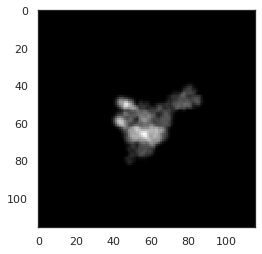

In [10]:
sampleProj = projections[1,:,:]
plt.imshow(sampleProj,cmap='gray')
plt.show()

In [11]:
def add_gaussian_noise(projections, noise_var):
    noise_sigma   = noise_var**0.5
    nproj,row,col = projections.shape
    gauss_noise   = np.random.normal(0,noise_sigma,(nproj,row,col))
    gauss_noise   = gauss_noise.reshape(nproj,row,col) 
    projections   = projections + gauss_noise
    return projections

In [12]:
def add_triangle_translation(projections, left_limit, peak_limit, right_limit):
    horizontal_shift = np.random.triangular(left_limit, peak_limit, right_limit, len(projections))
    vertical_shift   = np.random.triangular(left_limit, peak_limit, right_limit, len(projections))
    for i, (hs, vs) in enumerate(zip(horizontal_shift, vertical_shift)):
        # shift 1 place in horizontal axis
        projections[i] = np.roll(projections[i], int(hs), axis=0)
        # shift 1 place in vertical axis
        projections[i] = np.roll(projections[i], int(vs), axis=1) 
    return projections

In [13]:
# Add zero-mean Gaussian noise on the projections 
projections = add_gaussian_noise(projections, NOISY_VAR)
projections = add_triangle_translation(projections, left_limit=-TRANSLATION, peak_limit=0, right_limit=TRANSLATION)

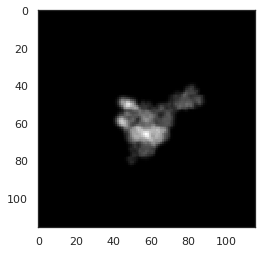

In [14]:
# Display projections with/out noise (for comparison)
sampleProj = projections[1,:,:]
plt.imshow(sampleProj,cmap='gray')
plt.show()

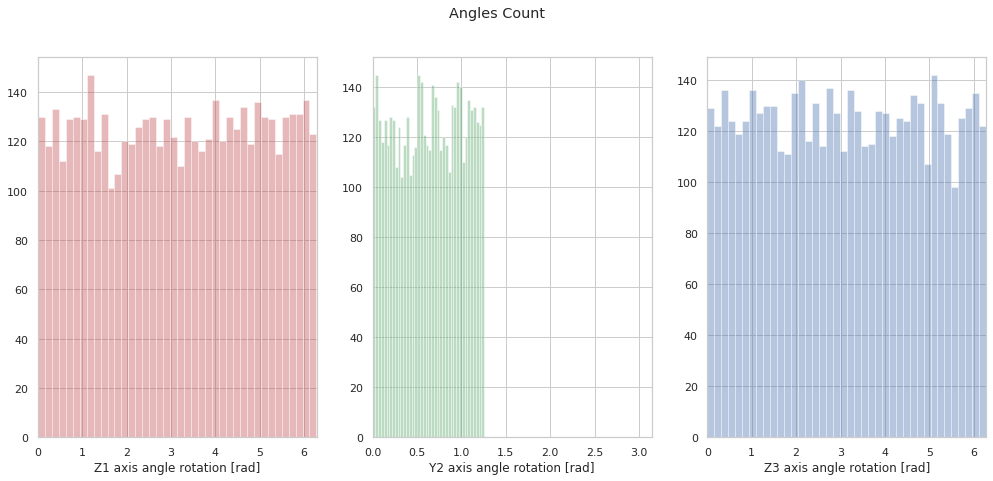

In [15]:
plot_angles_count(angles_true)

In [16]:
from cryoem.distance_estimation import global_standardization

In [17]:
X, y = np.array(projections, dtype=np.float32), np.array(angles_true, dtype=np.float32)

In [18]:
X = global_standardization(X)

Image shape: (116, 116)
Data Type: float32
***
Mean: 0.262 | Std: 1.046
Min:  0.000 | Max: 15.458
Mean: 0.000 | Std: 1.000
Min:  -0.250 | Max: 14.526


In [19]:
channels = "gray"
if channels == "rgb":
    X = np.stack((X,)*3, axis=-1)
elif channels == "gray":
    X = X[:,:,:,np.newaxis]

In [20]:
X.shape

(5000, 116, 116, 1)

---

## Angle Recovery: Estimated Distance FULL

In [21]:
model_filename = f"/mnt/scratch/students/translation{TRANSLATION}.h5"

# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 512)          4551936     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           model[1][0]                

In [22]:
from cryoem.conversions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ

In [23]:
def d_p(p1, p2):
    p1 = tf.cast(p1, dtype=tf.float32)
    p2 = tf.cast(p2, dtype=tf.float32)
    return model.predict([p1, p2], batch_size=512)

In [24]:
batch_size = 512
idx1 = list(np.random.choice(range(5000), size=batch_size))
idx2 = list(np.random.choice(range(5000), size=batch_size))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

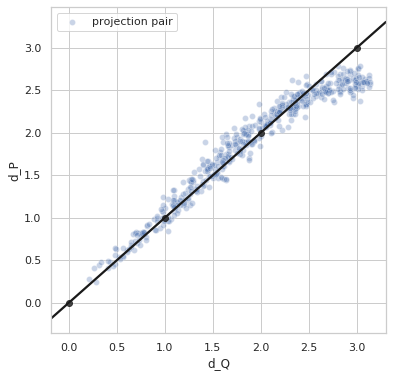

<Figure size 432x288 with 0 Axes>

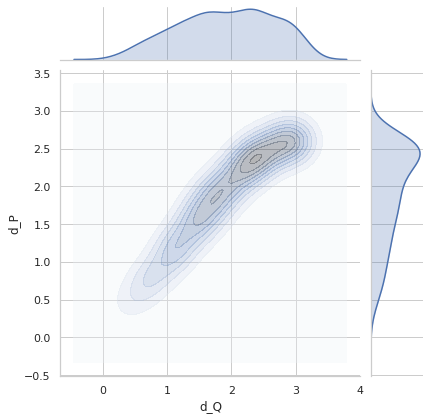

Variance = 0.1882964907967928
Min. angle recovery loss possible = 0.035386319289264834


In [25]:
plot_dP_dQ(dP_values, dQ_values);

#### Angle Recovery

In [26]:
from cryoem.angle_recovery import train_angle_recovery

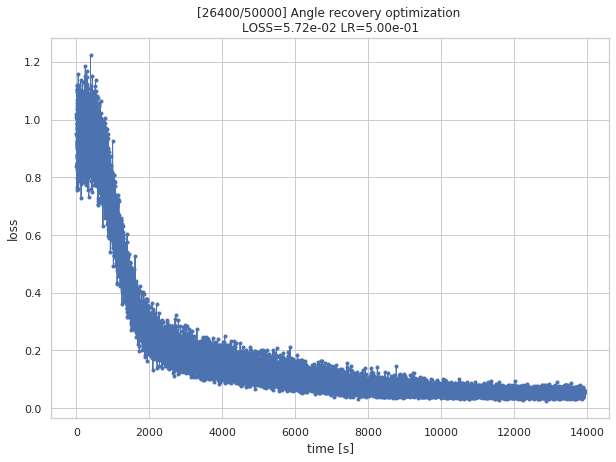

Shape of projections: (5000, 116, 116, 1)step 5000/50000 (2367s): loss = 2.12e-01
step 10000/50000 (4795s): loss = 1.07e-01
step 15000/50000 (7349s): loss = 6.42e-02
step 20000/50000 (10101s): loss = 4.90e-02
step 25000/50000 (13046s): loss = 4.65e-02
step 26400/50000 (13911s): loss = 5.96e-02



In [27]:
q_predicted, losses, q_all = train_angle_recovery(steps=50000, 
                             batch_size=256, 
                             in_data=X, 
                             distance_fn=d_p, 
                             learning_rate=0.5, 
                             limit_distance=np.pi,
                             file_name=f"/mnt/scratch/students/angle_recovery_translation{TRANSLATION}_limited3.14_estimated_50k")

In [26]:
from cryoem.conversions import quaternion2euler

In [27]:
data = np.load(f"/mnt/scratch/students/angle_recovery_translation{TRANSLATION}_limited3.14_estimated_50k.npz")
q_predicted, losses, q_all = data["arr_0"], data["arr_1"], data["arr_2"]

angles_predicted = quaternion2euler(q_predicted)

In [28]:
np.save("/mnt/scratch/students/5j0n_angles_true_translation5.npy", angles_true)
np.save("/mnt/scratch/students/5j0n_angles_predicted_translation5.npy", angles_predicted)

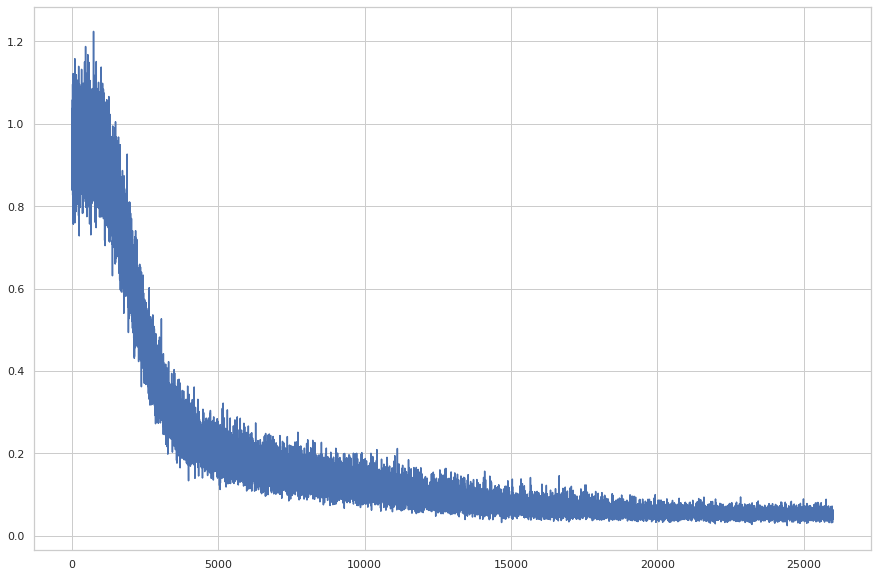

In [29]:
import seaborn as sns; sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(losses[:26000])
plt.show()

In [30]:
np.mean(losses[:26000][-10:])

0.051554071175521646

In [31]:
#np.save("data/5j0n/projections_limited2.5_estimated_50k", projections)
#np.save("data/5j0n/angles_true_limited2.5_estimated_50k", angles_true)
#np.save(f"/mnt/scratch/studetns/angles_predicted_noisy{NOISY_VAR}_limited3.14_estimated_50k", angles_predicted)

In [56]:
from cryoem.plots import plot_euclidean_space, plot_iterations_polar_plot, plot_polar_plot, plot_rotvec, plot_iterations_rotvec, plot_only_selected_in_euclidean_space

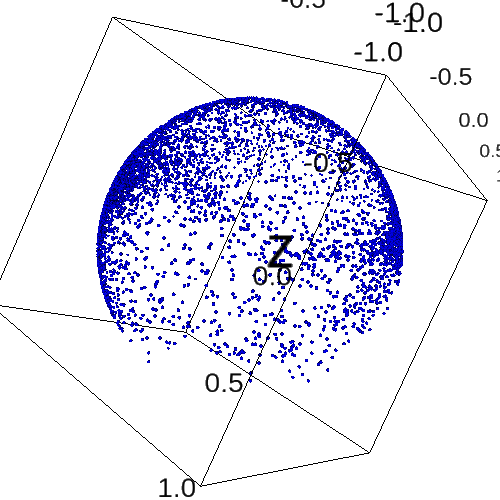

In [33]:
plot_euclidean_space(angles_predicted)

In [34]:
ipv.screenshot()

Output()

In [39]:
angles_true.shape

(5000, 3)

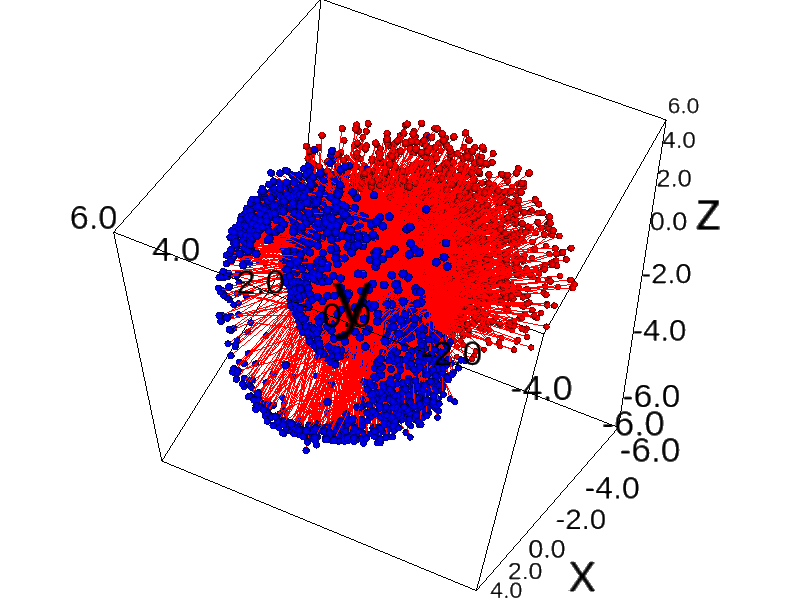

In [42]:
plot_iterations_polar_plot(q_predicted[np.newaxis,:,:], angles_true)

In [44]:
ipv.screenshot()

Output()

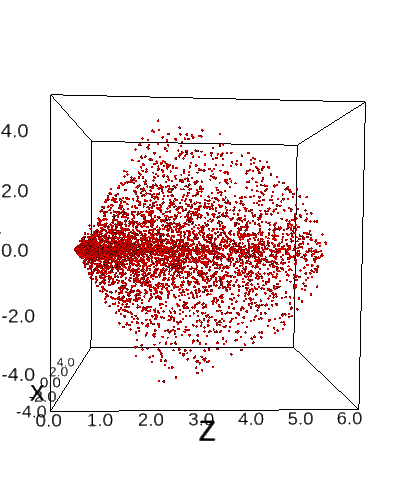

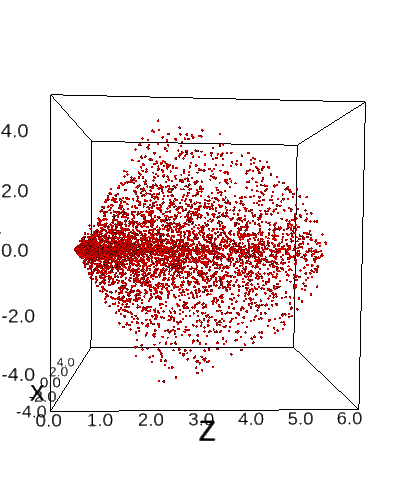

In [48]:
plot_polar_plot(angles_true)

In [49]:
ipv.screenshot()

Output()

In [47]:
plot_polar_plot(angles_predicted)

In [50]:
ipv.screenshot()

Output()

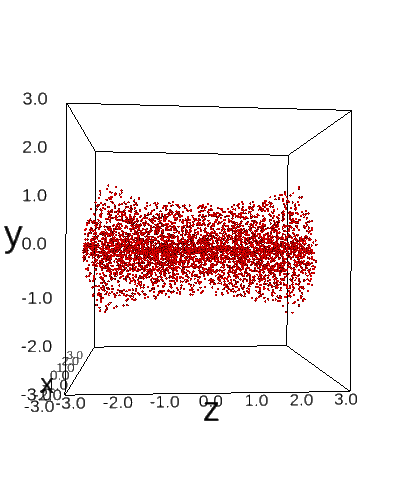

In [52]:
plot_rotvec(angles_true)

In [53]:
ipv.screenshot()

Output()

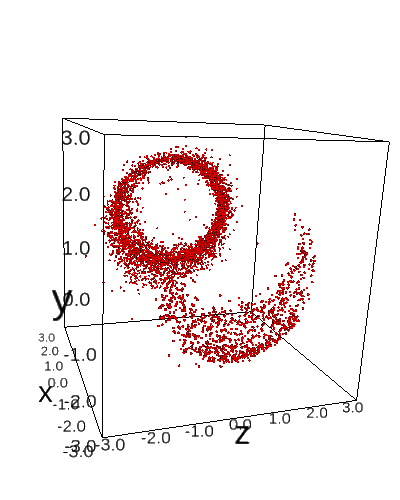

In [54]:
plot_rotvec(angles_predicted)

In [55]:
ipv.screenshot()

Output()

In [85]:
plot_only_selected_in_euclidean_space(angles_predicted, angles_true, range(500))

In [60]:
ipv.screenshot()

Output()

### Angle Alignment

In [61]:
from cryoem.angle_alignment import training_angle_alignment, update_quaternion
from tensorflow.keras.optimizers import Adagrad, Ftrl

In [68]:
import tensorflow as tf
from tensorflow_graphics.geometry.transformation import quaternion
from time import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="white", color_codes=True)
import random
from tensorflow_graphics.math import vector
from itertools import product
import time
from IPython import display as IPyDisplay
from scipy.spatial.transform import Rotation as R
from cryoem.conversions import euler2quaternion, d_q


def euler6tomarix4d(a_R):

    xy, xz, xw, yz, yw, zw = tf.unstack(a_R, axis=-1)
    
    cxy = tf.cos(xy)
    cxz = tf.cos(xz)
    cxw = tf.cos(xw)
    cyz = tf.cos(yz)
    cyw = tf.cos(yw)
    czw = tf.cos(zw)
    
    sxy = tf.sin(xy)
    sxz = tf.sin(xz)
    sxw = tf.sin(xw)
    syz = tf.sin(yz)
    syw = tf.sin(yw)
    szw = tf.sin(zw)
    
    # Note: wasn't able to create it as simple as np.ndarrays...
    Rxy = [[  cxy,  -sxy, [0.0], [0.0]], 
           [  sxy,   cxy, [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxy = tf.reshape(tf.convert_to_tensor(Rxy, dtype=tf.float64), (4, 4)) 
    
    Rxz = [[  cxz, [0.0],  -sxz, [0.0]],
           [[0.0], [1.0], [0.0], [0.0]],
           [  sxz, [0.0],   cxz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Rxz = tf.reshape(tf.convert_to_tensor(Rxz, dtype=tf.float64), (4, 4))
    
    Rxw = [[  cxw, [0.0], [0.0],  -sxw],
           [[0.0], [1.0], [0.0], [0.0]],
           [[0.0], [0.0], [1.0], [0.0]], 
           [  sxw, [0.0], [0.0],  cxw]]
    Rxw = tf.reshape(tf.convert_to_tensor(Rxw, dtype=tf.float64), (4, 4))
    
    Ryz = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyz,  -syz, [0.0]],
           [[0.0],   syz,   cyz, [0.0]],
           [[0.0], [0.0], [0.0], [1.0]]]
    Ryz = tf.reshape(tf.convert_to_tensor(Ryz, dtype=tf.float64), (4, 4))
    
    Ryw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0],   cyw, [0.0],  -syw],
           [[0.0], [0.0], [1.0], [0.0]],
           [[0.0],   syw, [0.0],  cyw]]
    Ryw = tf.reshape(tf.convert_to_tensor(Ryw, dtype=tf.float64), (4, 4))
    
    Rzw = [[[1.0], [0.0], [0.0], [0.0]],
           [[0.0], [1.0], [0.0], [0.0]], 
           [[0.0], [0.0],   czw,  -szw],
           [[0.0], [0.0],   szw,  czw]]
    Rzw = tf.reshape(tf.convert_to_tensor(Rzw, dtype=tf.float64), (4, 4))
  
    R = Rxy @ Rxz @ Rxw @ Ryz @ Ryw @ Rzw

    # check if matrix is orthogonal: R^T @ R - I < 1e-5
    assert tf.reduce_all(tf.less_equal(tf.abs(tf.subtract(tf.transpose(R) @ R, tf.eye(4, 4, dtype=tf.float64))), 1e-5)), "Matrix R (4x4) should be orthogonal!" 
        
    return R


def update_quaternion(m, a_R, q_predicted):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return q_predicted_rotated

def loss_alignment(m, a_R, q_predicted, q_true):
    # 4D matrix rotation
    R = euler6tomarix4d(a_R)
    I = tf.linalg.diag(tf.convert_to_tensor(m, dtype=tf.float64))
    q_predicted_rotated = tf.transpose(R @ I @ tf.transpose(q_predicted))

    return tf.reduce_mean(d_q(q_true, q_predicted_rotated))


def gradient_alignment(m, a_R, q_predicted, q_true):
    with tf.GradientTape() as tape:
        loss_value = loss_alignment(m, a_R, q_predicted, q_true)
        gradient = tape.gradient(loss_value, a_R)
        
    return loss_value, gradient


def training_angle_alignment(num_runs, steps, batch_size, optimizer, angles_true, angles_predicted):
    
    def _inner(m, steps, batch_size, optimizer, angles_true, angles_predicted, title):
        collect_data = []

        time_start = time.time()

        report = ""

        losses = np.empty(steps)
        angles_predicted = tf.convert_to_tensor(angles_predicted)
        learning_rate = optimizer.lr.numpy()

        trajectory = np.zeros([steps + 1, 6])
        euler = tf.random.uniform([6], 0, 2*np.pi, dtype=tf.float64) 
        a_R = [tf.Variable(euler)]
        trajectory[0, :] = a_R[0].numpy()

        q_predicted = euler2quaternion(angles_predicted)
        q_true = euler2quaternion(angles_true)

        for step in range(1, steps+1):

            # Sample some pairs.
            idx = list(np.random.choice(range(len(angles_predicted)), size=batch_size))

            # Compute distances between projections
            qt = [q_true[i]      for i in idx]
            qp = [q_predicted[i] for i in idx]

            # Optimize by gradient descent.
            losses[step-1], gradients = gradient_alignment(m, a_R, qp, qt)
            optimizer.apply_gradients(zip(gradients, a_R))
            trajectory[step, :] = a_R[0].numpy()
            
            update_lr = 300
            if step>update_lr and step%update_lr==0 and losses[step-1]-losses[step-1-update_lr+100] < 0.1:
                learning_rate *= 0.1

            # Visualize progress periodically
            if step % 10 == 0:
                qu = update_quaternion(m, a_R, q_predicted)

                collect_data.append(qu.numpy())

                plt.close();
                sns.set(style="white", color_codes=True)
                sns.set(style="whitegrid")

                fig, axs = plt.subplots(1, 3, figsize=(24,7))
                plt.title(title, fontsize=22)

                # Distance count subplot (batches)
                qpr = update_quaternion(m, a_R, qp)
                d1 = d_q(qpr, qt)
                axs[0].set_xlim(0, np.pi)
                #axs[0].set_ylim(0, batch_size)
                axs[0].set_title(f"BATCHES (size={len(qp)}): [{step}/{steps}] Distances between true and predicted angles \nMEAN={np.mean(d1):.2e} STD={np.std(d1):.2e}")
                s = sns.distplot(d1, kde=False, bins=100, ax=axs[0], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[0].plot([np.mean(d1)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                # Optimization loss subplot
                axs[1].plot(np.linspace(0, time.time()-time_start, step), losses[:step], marker="o", lw=1, markersize=3)
                axs[1].set_xlabel('time [s]')
                axs[1].set_ylabel('loss');
                axs[1].set_title(f"Angle alignment optimization \nLOSS={np.mean(losses[step-10:step]):.2e} LR={learning_rate:.2e}")

                # Distance count subplot (full)
                q_predicted_rot = update_quaternion(m, a_R, q_predicted)
                d2 = d_q(q_predicted_rot, q_true)
                axs[2].set_xlim(0, np.pi)
                # axs[2].set_ylim(0, len(angles_true))
                axs[2].set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
                s = sns.distplot(d2, kde=False, bins=100, ax=axs[2], axlabel="Distance [rad]", color="r")
                max_count = int(max([h.get_height() for h in s.patches]))
                axs[2].plot([np.mean(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)

                

                IPyDisplay.clear_output(wait=True)
                IPyDisplay.display(plt.gcf())
                plt.close();
                time.sleep(.1)


            # Periodically report progress.
            if ((step % (steps//10)) == 0) or (step == steps):
                time_elapsed = time.time() - time_start
                report += f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {np.mean(losses[step-steps//10:step-1]):.2e}\n'

            if step >= 101 and np.mean(losses[step-101:step-1]) < 1e-3:
                break;

        print(report)
        return m, a_R, losses, np.array(collect_data), trajectory
    
    d = {'m':[], 'a_R':[], 'losses':[], 'collect_data':[], 'trajectory':[]}
    for i in range(num_runs):
        for m in product([-1, 1], repeat=4):
            print("m = ", m)
            time.sleep(1)
            title = f"run {i+1}/{num_runs+1} | m = {m}"
            m, a_R, losses, collect_data, trajectory = _inner(m, steps, batch_size, optimizer, angles_true, angles_predicted, title)
            d['m'].append(m)
            d['a_R'].append(a_R)
            d['losses'].append(losses)
            d['collect_data'].append(collect_data)
            d['trajectory'].append(trajectory)
    
    plt.close();
    IPyDisplay.clear_output(wait=True)
    
    losses = np.array([l[-1] for l in d['losses']])
    idx = np.argmin(losses)
    
    return d['m'][idx], d['a_R'][idx], d['losses'][idx], d['collect_data'][idx], d['trajectory'][idx],

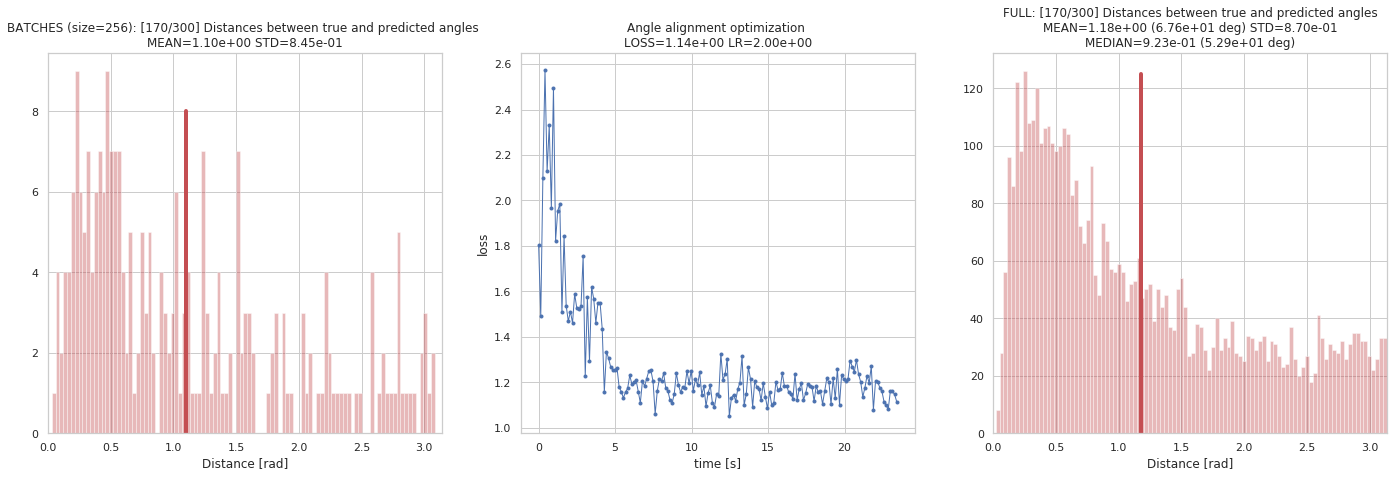

In [ ]:
m, a_R, losses, collect_data, trajectory = training_angle_alignment(num_runs=2, 
                                                        steps=300, 
                                                        batch_size=256, 
                                                        optimizer=Ftrl(learning_rate=2., learning_rate_power=-2.), 
                                                        angles_true=angles_true, 
                                                        angles_predicted=angles_predicted)

In [73]:
losses[-1], m, a_R

(1.0438223803613975,
 (-1, -1, 1, 1),
 [<tf.Variable 'Variable:0' shape=(6,) dtype=float64, numpy=
  array([ 0.64612025, 35.30912886, 10.20013382, -2.08609986, 13.52371694,
         14.05119799])>])

In [76]:
m = m
trajectory_first = trajectory[0]
loss_first = losses[0]
trajectory_last = trajectory[-1]
loss_last = losses[-1]

In [77]:
m, trajectory_first, loss_first, trajectory_last, loss_last

((-1, -1, 1, 1),
 array([5.57664952, 2.42877645, 2.0915598 , 2.30039975, 4.51441516,
        4.17915868]),
 1.9249245232031793,
 array([ 0.64612025, 35.30912886, 10.20013382, -2.08609986, 13.52371694,
        14.05119799]),
 1.0438223803613975)

In [78]:
tick_size=15
label_size=15

(5000, 4)
(5000, 4)


Text(0.77, 0.72, '$E$ = 1.9249 rad')

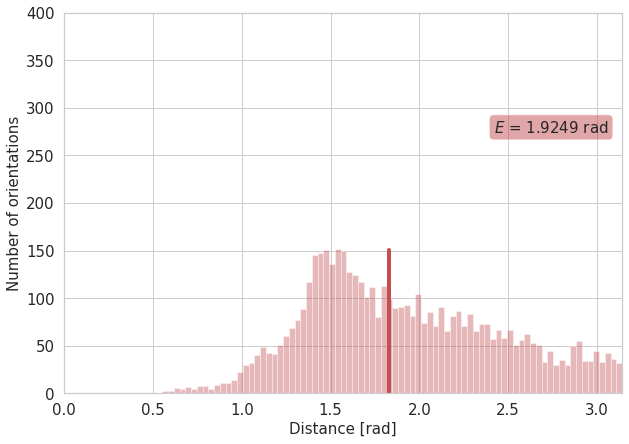

In [79]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
print(q_predicted.shape)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_first)], q_predicted))
print(q_predicted_rot.shape)
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 400)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=80, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.77, 0.72, f"$E$ = {loss_first:.4f} rad", transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)

Text(0.03, 0.95, '$E$ = 1.0438 rad')

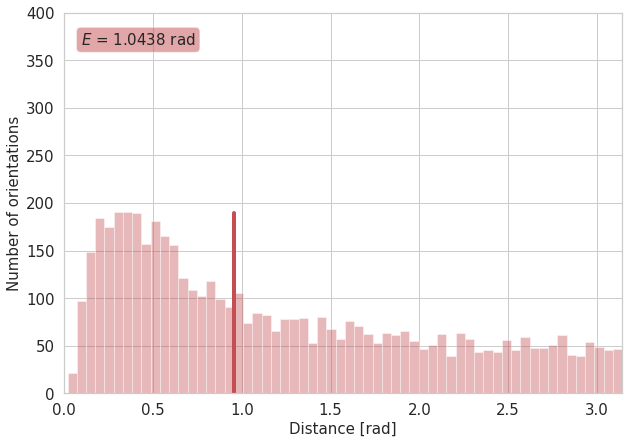

In [80]:
fig, ax = plt.subplots(figsize=(10,7))
# Distance count subplot (full)
q_predicted_rot = np.squeeze(update_quaternion(m, [tf.Variable(trajectory_last)], q_predicted))
d2 = d_q(q_predicted_rot, euler2quaternion(angles_true))
ax.set_xlim(0, np.pi)
ax.set_ylim(0, 400)
#ax.set_title(f"FULL: [{step}/{steps}] Distances between true and predicted angles\nMEAN={np.mean(d2):.2e} ({np.degrees(np.mean(d2)):.2e} deg) STD={np.std(d2):.2e}\nMEDIAN={np.median(d2):.2e} ({np.degrees(np.median(d2)):.2e} deg)")
s = sns.distplot(d2, kde=False, bins=60, ax=ax, color="r")
max_count = int(max([h.get_height() for h in s.patches]))
ax.plot([np.median(d2)]*max_count, np.arange(0, max_count,1), c="r", lw=4)
plt.xlabel("Distance [rad]", fontsize=tick_size)
plt.ylabel("Number of orientations", fontsize=tick_size)
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=label_size)


props = dict(boxstyle='round', facecolor='r', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.03, 0.95, f"$E$ = {loss_last:.4f} rad", transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props)

In [81]:
q_predicted_rotated =  update_quaternion(m, a_R, q_predicted)

angles_predicted_rotated = quaternion2euler(q_predicted_rotated)

#np.save(f"/mnt/scratch/studetns/angles_predicted_rotated_noisy{NOISY_VAR}_limited3.14_estimated_50k", angles_predicted_rotated)

In [82]:
from cryoem.plots import plot_iterations_polar_plot, plot_iterations_rotvec

In [83]:
plot_iterations_polar_plot(collect_data, angles_true, interval=200, connections=False, selected=None)

In [46]:
ipv.screenshot()

Output()

In [84]:
plot_iterations_rotvec(collect_data, angles_true, interval=200)

In [87]:
plot_only_selected_in_euclidean_space(angles_predicted_rotated, angles_true, range(500))